In [1]:
#imports


from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math as m
from scipy.optimize import curve_fit
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline

#function to read from fits file
def readdata(s):

  
  with fits.open(s) as hdul:
    mydata = np.array(hdul[1].data)
    sz = mydata.size
    data1 = np.zeros(sz)
    data2 = np.zeros(sz)
    data3 = np.zeros(sz)
    #data1 = mydata[:,0]
    for i in range(sz):
        data1[i] = mydata[i][0]
        data2[i] = mydata[i][1]
        data3[i] = mydata[i][2]
    return data1,data2,data3



#function for binning
def resolution(r, arr):
    arr2 = np.zeros(len(arr)//r)
    for i in range(len(arr)//r):
        sum = 0
        for j in range(r):
            sum += arr[r*i + j]
        sum/= r
        arr2[i] = sum
    return arr2

#smoothening
def smoothen(arr):
    smoothed_signal = convolve(arr, Box1DKernel(11))
    return smoothed_signal

'''
    for i in range(2, len(arr)-3):
        arr[i] = (arr[i-2] + arr[i-1] + arr[i] + arr[i+1] + arr[i+2])/5
    return arr
'''

def process_marks(marks_list, peak_times): #takes the list of flares with redundancies and removes them. 
    #Finds accurate start and end times based on increasing decreasing logic
    
    final_m = []
    for i in peak_times:
        time_min = []
        time_max = []
        for j in marks_list:
            if j[1] == i:
                time_min.append(min(j[0], j[2]))
                time_max.append(max(j[0], j[2]))
        final_m.append([min(time_min), i, max(time_max)])
    
    return final_m





def prepare_data(s): #reads data, bins and smoothens it and returns a list of 2 arrays, one containing times and the other intensities
    dat = list(readdata(s))
    dat[0] = dat[0] - dat[0][0]

    sz = len(dat[0])
    #dat[1] = smoothen(dat[1])
    #dat[1] = smoothen(dat[1])
    dat[0] = resolution(80,dat[0])
    dat[1] = resolution(80,dat[1])
    dat[2] = resolution(80,dat[2])
    dat[1] = smoothen(dat[1])
    dat[2] = smoothen(dat[2])
    dat[0] = dat[0][5:-5]
    dat[1] = dat[1][5:-5]
    dat[2] = dat[2][5:-5]
    return dat


def display_data(dat): #main function that displays the data and any peaks in it

    dat2 = [np.zeros(len(dat[0])), np.zeros(len(dat[0]))] 
    mean, median, std, max_val = analyse_data(dat[1]) #get some details of the distribution
    dat2[0] = dat[0]
    dat2[1] = np.where(dat[1]<30, dat[1], 30) #dat2 is created to work with small flares in the prescence of big ones
    
    flares_i, flares_t, flare_marks = find_flares(dat[1],dat[0])#finds the coordinates of flare peaks
    
    flare_marks = process_marks(flare_marks, flares_t)
            
    
    plt.figure(figsize = (18,5))
    plt.xlabel('time')
    plt.ylabel('intensity')
    
    #code to separate the flare markings into the 2 graphs we will use for the plotting
    flares_t1 = []
    flares_t2 = []
    midpoint = dat[0][len(dat[0])//2]
    for i in flares_t:
        if i < midpoint:
            flares_t1.append(i)
        else:
            flares_t2.append(i)
    flares_i1 = flares_i[:len(flares_t1)]
    flares_i2 = flares_i[len(flares_t1):]
    
    #plotting
    plt.plot(dat[0],dat[1], color = 'red')
    plt.scatter(flares_t,flares_i)
    plt.title(s)
    plt.xlabel('time')
    plt.ylabel('intensity')


    plt.show()
    return flare_marks, dat[0], dat[1] #return the light data as well as the preliminary flare start, end data 
#without implementing background
    #plotting of small flares n prescence of big flares as well
    '''
    if max_val > 30:    
        plt.figure(figsize = (18,10))
        plt.xlabel('time')
        plt.ylabel('intensity')


        p1 = plt.subplot(2,1,1)
    #    p1.set_ylim(0,100)
        p1.plot(dat2[0][:len(dat[0])//2],dat2[1][:len(dat2[0])//2])
        plt.title(s)
        plt.xlabel('time')
        plt.ylabel('intensity')
        p2 = plt.subplot(2,1,2)
    #    p2.set_ylim(0,100)
        p2.plot(dat[0][len(dat2[0])//2:],dat2[1][len(dat2[0])//2:])
        plt.xlabel('time')
        plt.ylabel('intensity')
        plt.show()
    '''
    #print(flares_t)
    
def plot_flares(dat): #meant for plotting data, pass time and intensity arrays in one list dat
    p1 = plt.subplot(2,1,1)
#    p1.set_ylim(0,100)
    p1.plot(dat[0][:len(dat[0])//2],dat[1][:len(dat[0])//2], color = 'red')
    plt.title(s)
    plt.xlabel('time')
    plt.ylabel('intensity')
    p2 = plt.subplot(2,1,2)
#    p2.set_ylim(0,100)
    p2.plot(dat[0][len(dat[0])//2:],dat[1][len(dat[0])//2:], color = 'red')
    plt.xlabel('time')
    plt.ylabel('intensity')

    #plt.show()

def analyse_data(arr):  #returns some standard info about the distribution and prints it out as well
    mean = np.mean(arr)
    std = np.std(arr)
    print('mean', mean)
    print('std', std)
    median = np.median(arr)
    print('median', median)
    max_val = np.max(arr)
    print('max', max_val)
    increment = max_val - median
    print('increment', increment)
    return mean,median,std,max_val


def first_element(t):
    return t[0]

def find_flares(arr_f, times): #finds flare peaks
    flares_t = []
    flares_i = []
    flare_marks = []
    flare_peaks = []
    
    #forward search
    for i in range(len(arr_f)-3):
        if arr_f[i+3] > arr_f[i+2] > arr_f[i+1] > arr_f[i]:
            if arr_f[i+3] > 1.08*arr_f[i]:
                for j in range(i+3,len(arr_f)-2):
                    if arr_f[j] > arr_f[j+1] > arr_f[j+2]:
                        m = np.argmax(arr_f[i+3:j+1])
                        if times[i+3+m] not in flares_t:
                            flares_t.append(times[i+3+m])
                            flare_peaks.append((times[i+3+m],arr_f[i+3+m]))
                        flare_marks.append((times[i], times[i+3+m], times[j+2])) #allows for redundancy but gives proper start and end times
                            #print('row', i, m, j, times[i], arr_f[i], arr_f[i+3], arr_f[i+3+m], arr_f[j],arr_f[j+1], arr_f[j+2], times[j+2])
                        break
    #reverse and search again, look for peaks that havent already been found
    arr_f = arr_f[::-1]
    times = times[::-1]
    for i in range(len(arr_f)-3):
        if arr_f[i+3] > arr_f[i+2] > arr_f[i+1] > arr_f[i]:
            if arr_f[i+3] > 1.08*arr_f[i]:
                for j in range(i+3,len(arr_f)-2):
                    if arr_f[j] > arr_f[j+1] > arr_f[j+2]:
                        m = np.argmax(arr_f[i+3:j+1])
                        if times[i+3+m] not in flares_t:
                            flares_t.append(times[i+3+m])
                            flare_peaks.append((times[i+3+m],arr_f[i+3+m]))
                        flare_marks.append((times[i],times[i+3+m], times[j+2]))
                            #print('row', i, m, j, times[i], arr_f[i], arr_f[i+3], arr_f[i+3+m], arr_f[j],arr_f[j+1], arr_f[j+2], times[j+2])
                        break
    
    flare_peaks.sort(key = first_element)
    #print(flares)
    flares_t = []
    flares_i = []
    for i in flare_peaks:
        flares_i.append(i[1])
        flares_t.append(i[0])
    return flares_i,flares_t, flare_marks
    
#flare start and end times


def remove_flares(fl_marks, arr_t, arr_i): #removes data within fl_marks from intensity array
    #format of fl_marks is : list of [start time, peak time, end time]
    arr_i_sub = np.array(arr_i)
    arr_i2 = []
    arr_t2 = []
    for i in fl_marks:
        arr_i_sub[np.where(arr_t == i[0])[0][0]:np.where(arr_t == i[2])[0][0]] = 0
    
    for i in range(len(arr_i_sub)):
        if arr_i_sub[i] !=0:
            arr_i2.append(arr_i_sub[i])
            arr_t2.append(arr_t[i])
    return arr_i2, arr_t2

def shrink_std(arr): #shrinks std range by rejecting data outside 1 std
    arr2 = []
    mean = np.mean(arr)
    std = np.std(arr)
    for i in arr:
        if i > mean-std and i <mean+std:
            arr2.append(i)
    return arr2

def split_flare_marks(n,fl_marks,time_total):
    time_mark = time_total//n
    l_nested = []
    for mark_set in range(n):
        l_marks = []
        for mark in fl_marks:
            if mark[1] > time_mark*(mark_set+1):
                break
            else:
                if mark[2] > time_mark*(mark_set+1):
                    mark[2] = time_mark*(mark_set+1)
                if mark[0] < time_mark*(mark_set):
                    mark[0] = time_mark*(mark_set)
            l_marks.append(time_mark)
        l_nested.append(l_marks)
        
    return l_nested

def line(x,m,c):
    return m*x + c



def remove_outliers(time, intensity, m, c):
    std = np.std(intensity)
    t2 = []
    i2 = []
    for i in range(len(intensity)):
        if intensity[i] > m*time[i] + c + 3*std or intensity[i] < m*time[i] + c - 3*std:
            pass
        else:
            t2.append(time[i])
            i2.append(intensity[i])
    return t2, i2

def broken_lines(x,mark,_arr,c_arr):
    section = int(x//mark)
    m = m_arr[section]
    c = c_arr[section]
    return m*x+c


mean 36.673330733557115
std 30.291268797319873
median 26.80999897935174
max 191.4058237769387
increment 164.59582479758694


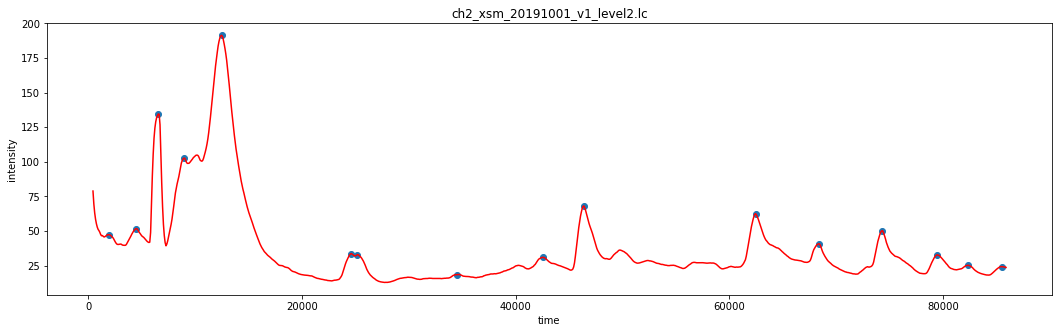

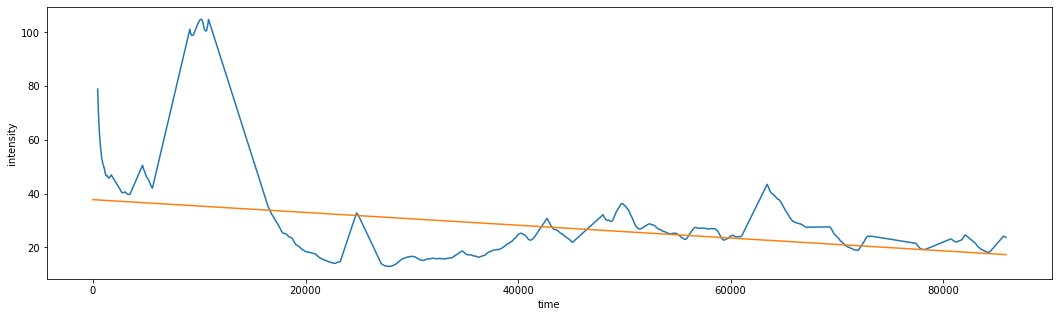

mark:  21481.375
break, array_bg_times etc ready 


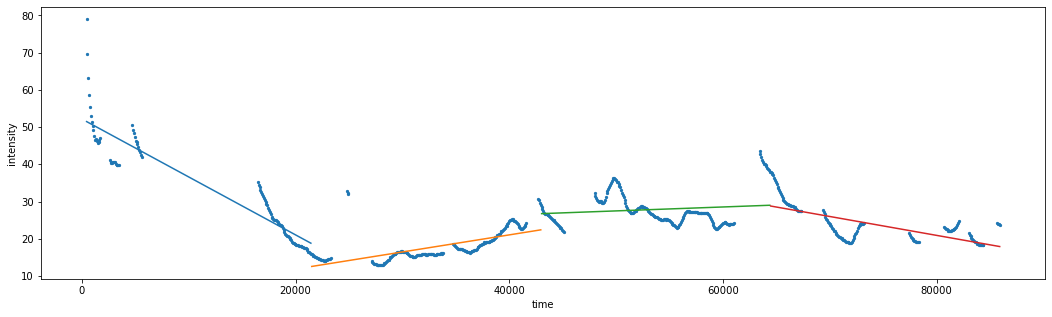

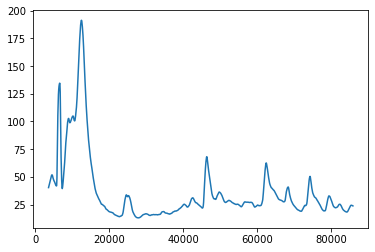

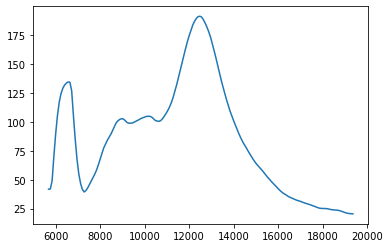

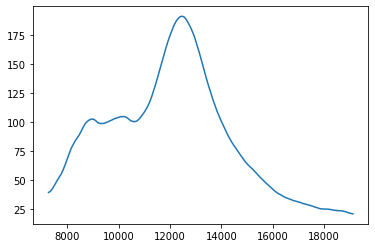

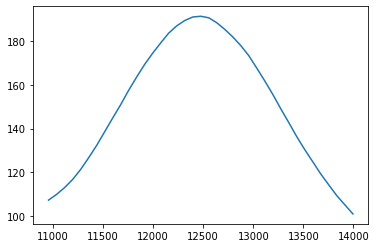

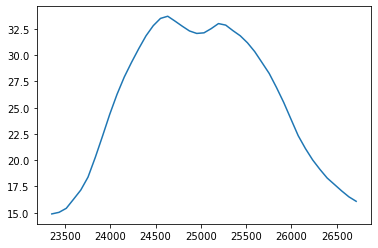

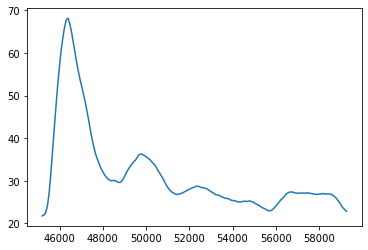

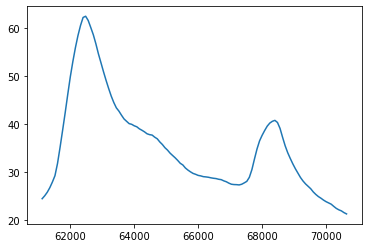

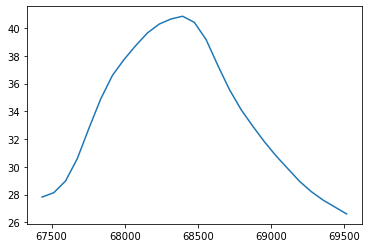

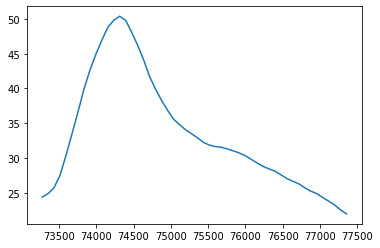

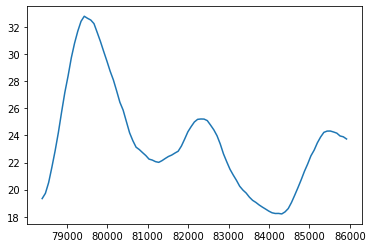

mean 19.30681611156934
std 7.195199756053013
median 17.963653771714732
max 77.16759197928687
increment 59.203938207572136


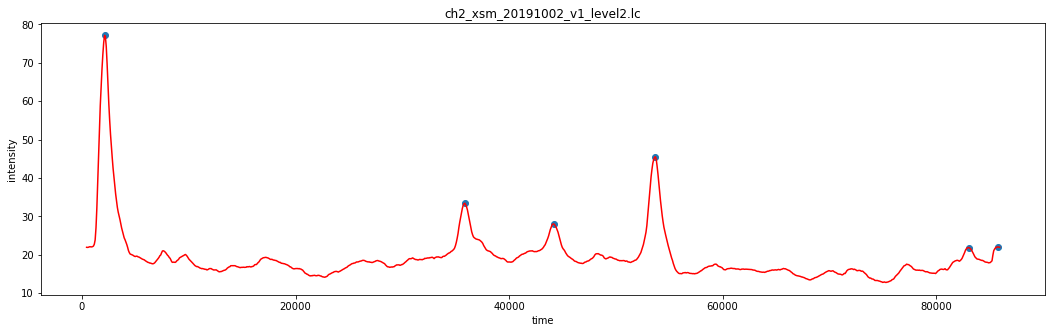

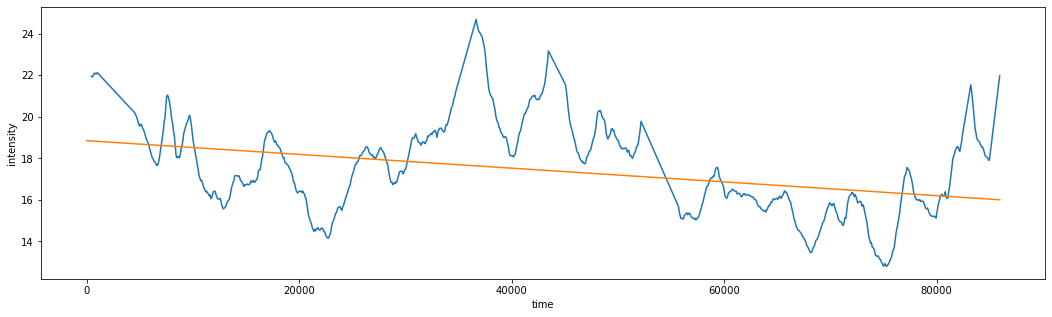

mark:  21487.125
break, array_bg_times etc ready 


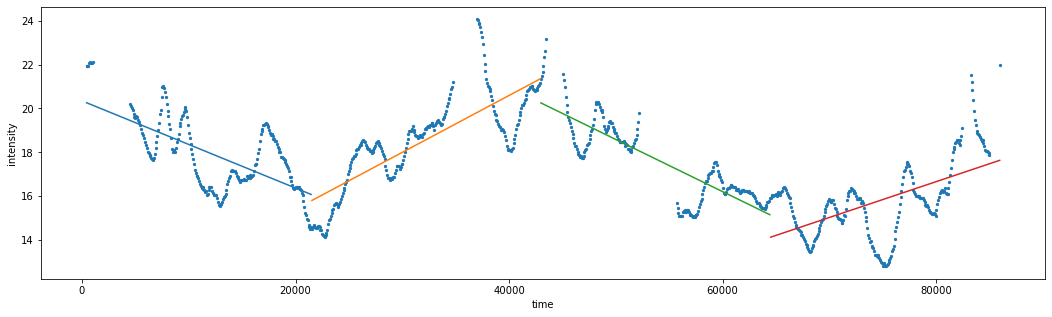

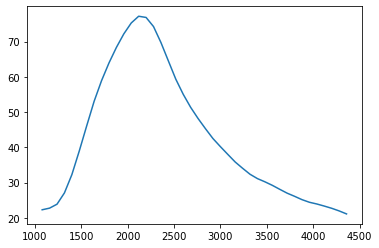

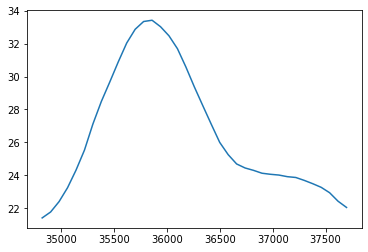

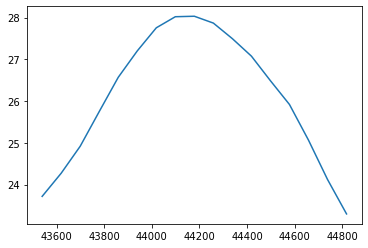

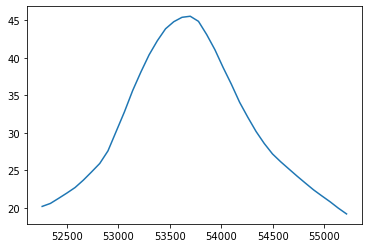

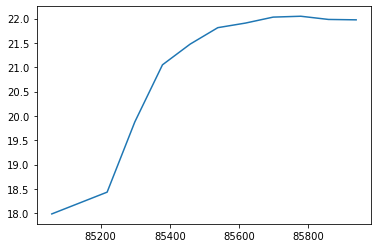

mean 12.329344987798233
std 1.69921194313524
median 12.070755727927795
max 18.33756292570721
increment 6.266807197779416


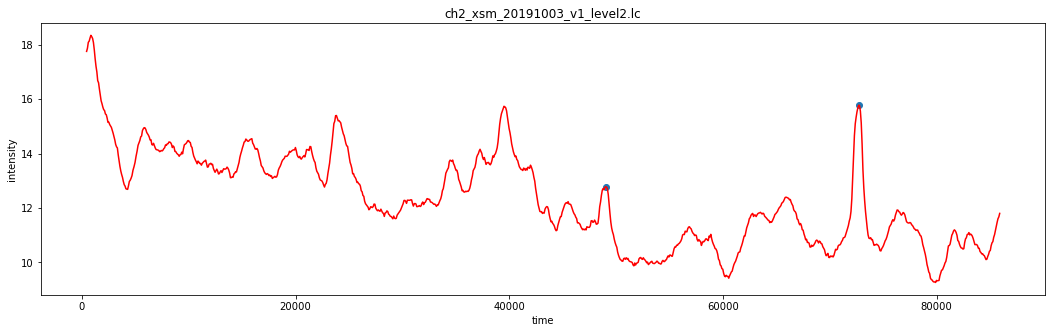

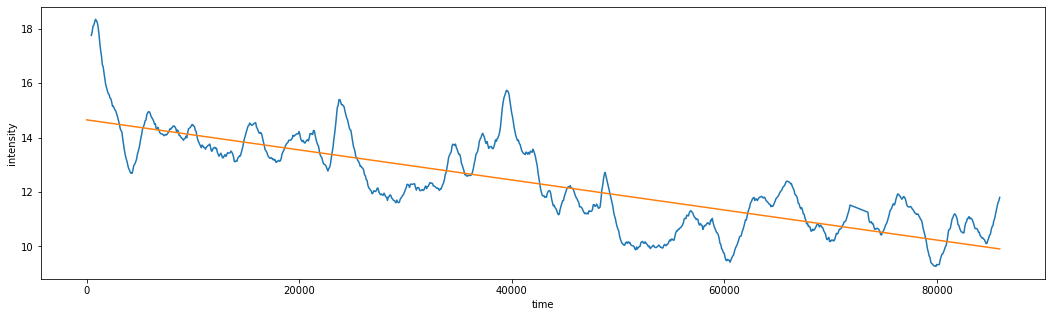

mark:  21479.375
break, array_bg_times etc ready 


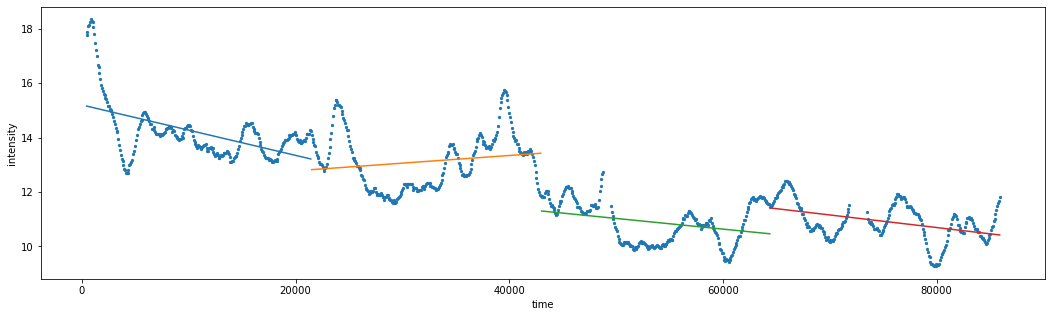

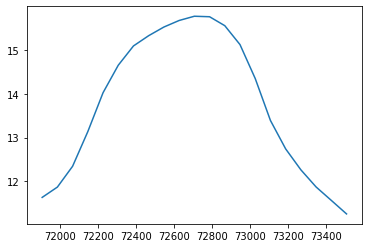

mean 12.47088163166216
std 7.234341734173165
median 10.83752419101921
max 75.25844797654584
increment 64.42092378552663


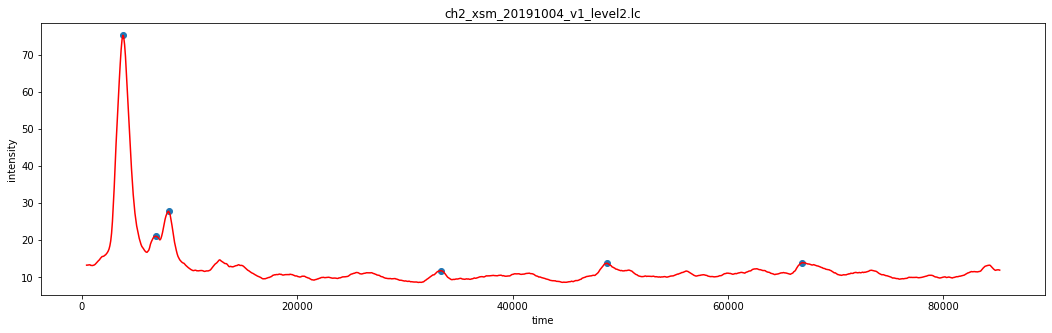

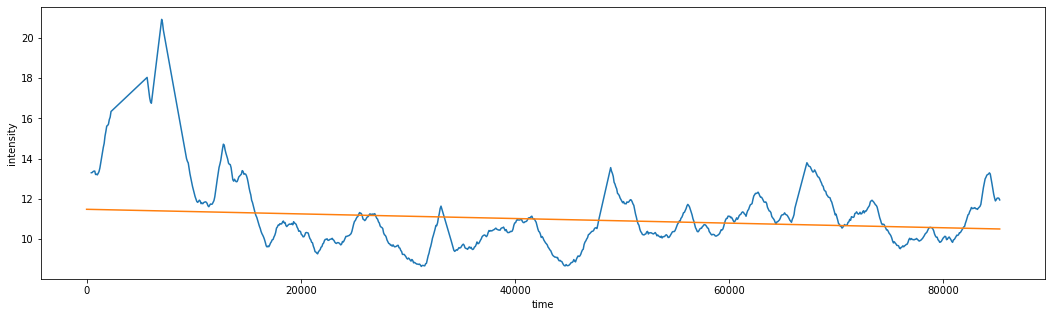

mark:  21314.625
break, array_bg_times etc ready 


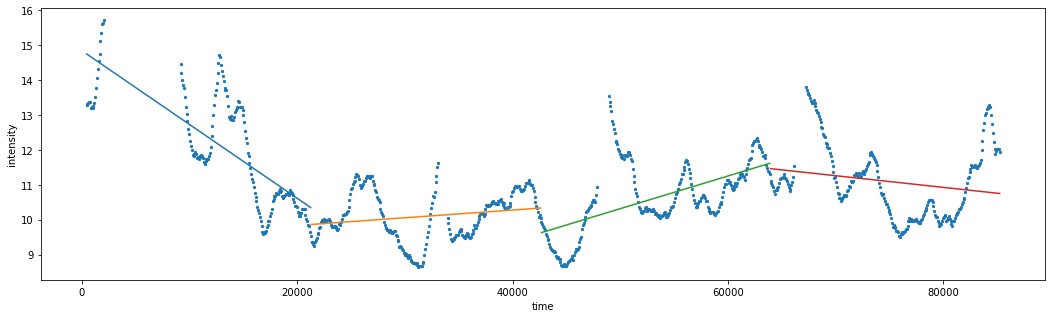

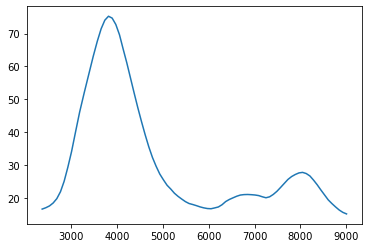

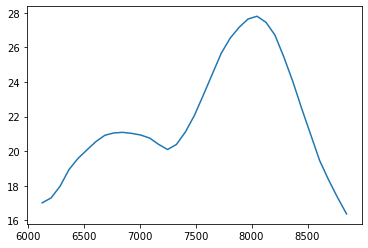

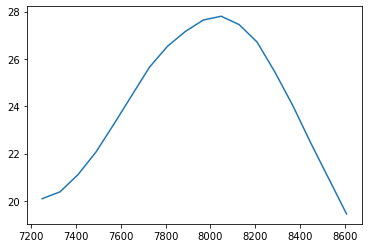

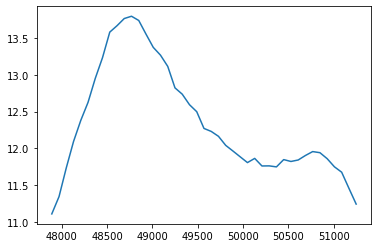

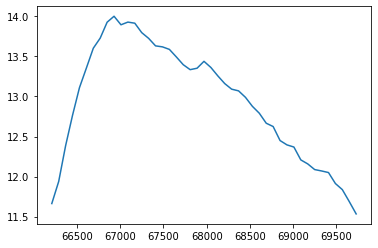

mean 10.1824683302811
std 1.8236961288797713
median 9.694657694616103
max 22.842709144678985
increment 13.148051450062882


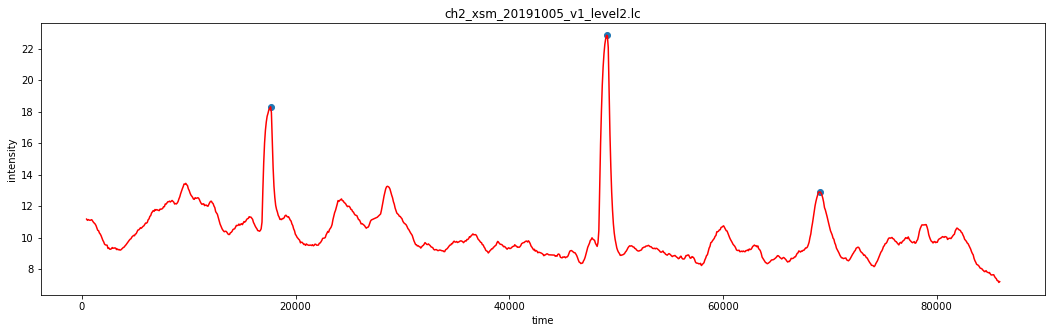

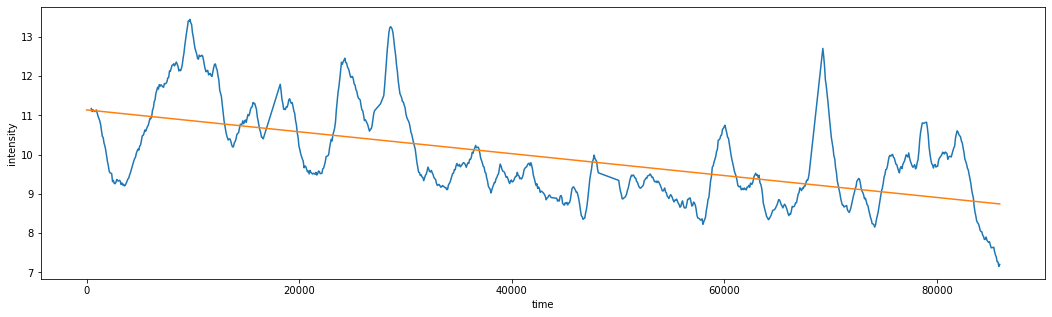

mark:  21479.375
break, array_bg_times etc ready 


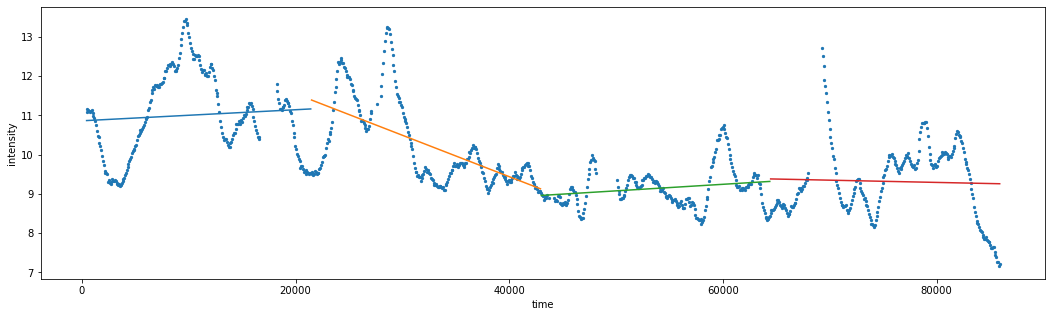

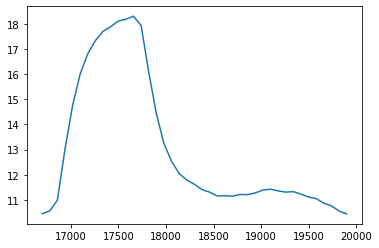

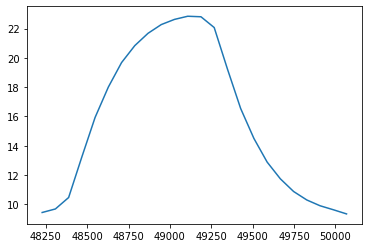

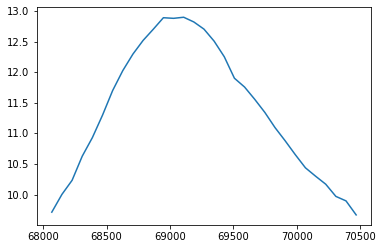

mean 6.592770245265007
std 0.7911140933853168
median 6.560920454290781
max 9.114769243652171
increment 2.55384878936139


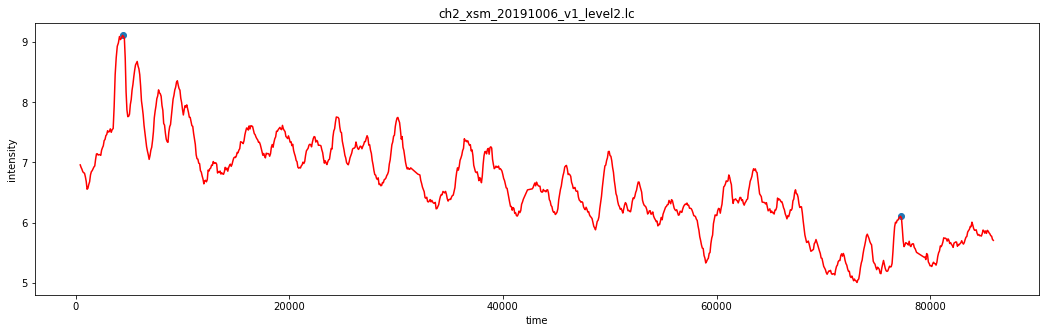

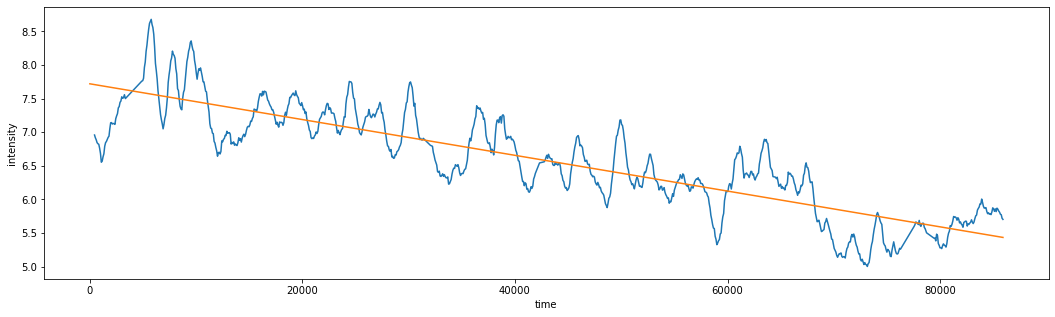

mark:  21479.875
break, array_bg_times etc ready 


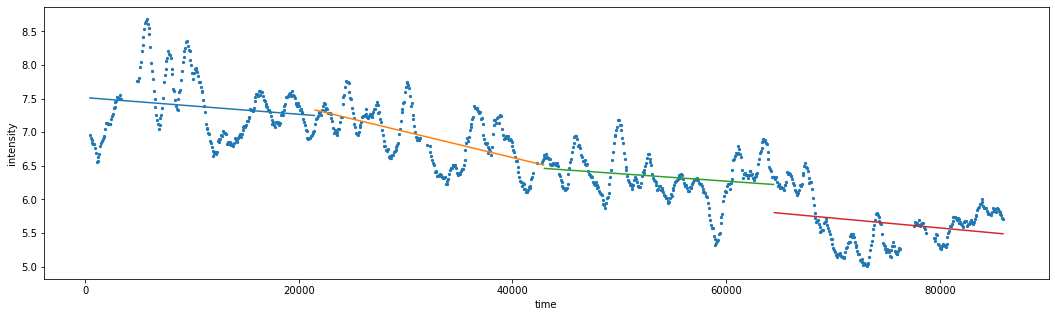

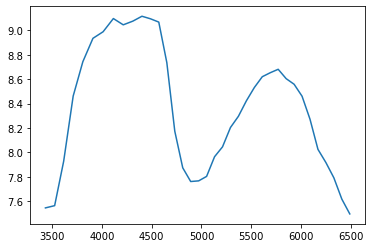

mean 5.806582934578646
std 0.3341511898887116
median 5.8042655882510275
max 7.5428928216749975
increment 1.73862723342397


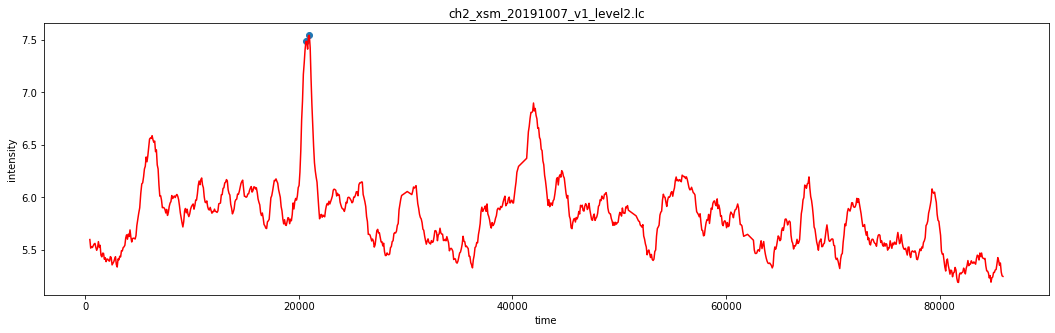

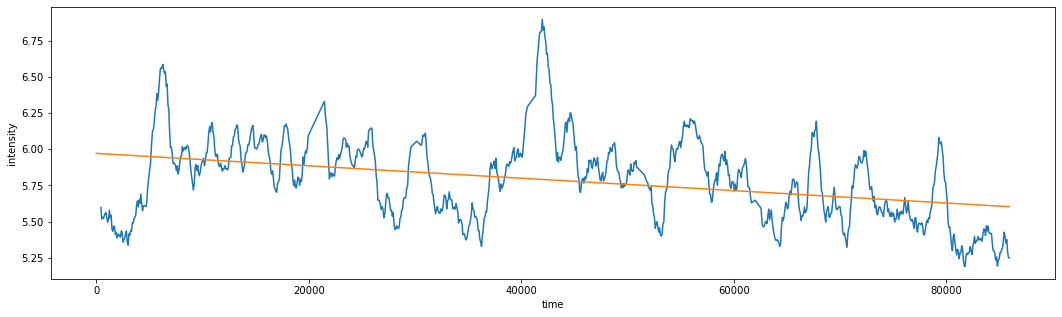

mark:  21486.125
break, array_bg_times etc ready 


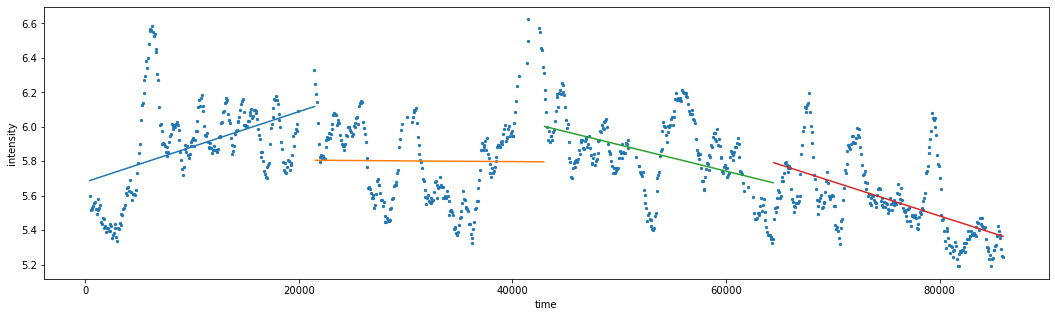

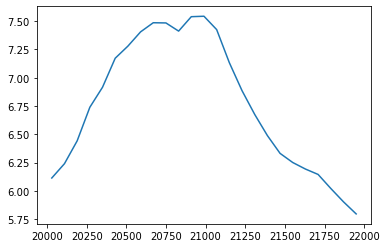

mean 5.209119428215795
std 0.4274168669679744
median 5.123133795640685
max 6.856849553097378
increment 1.733715757456693


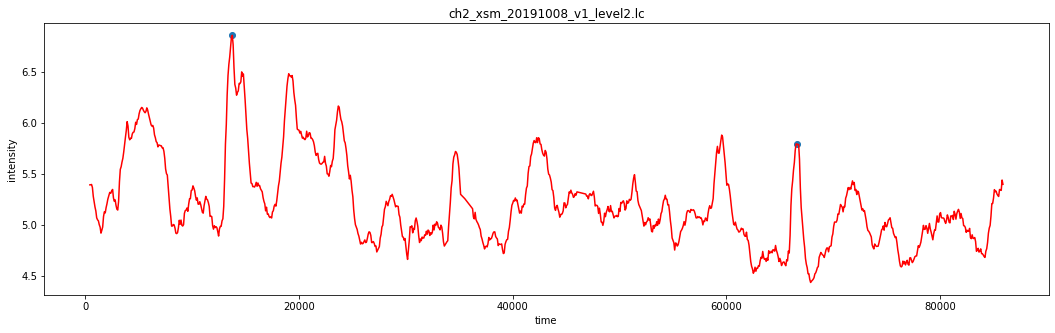

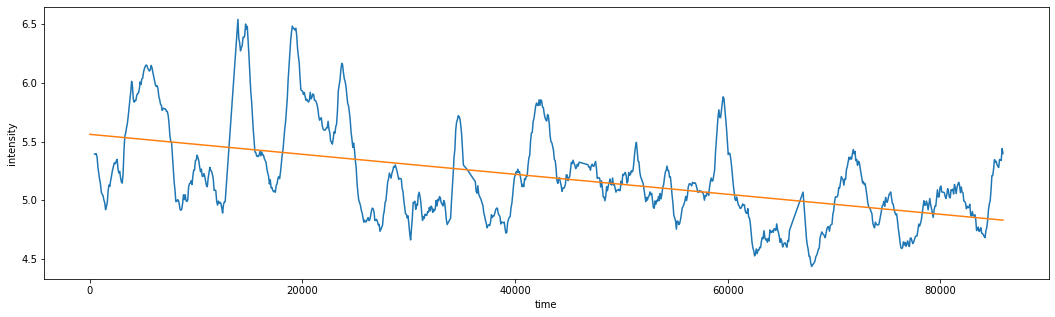

mark:  21474.625
break, array_bg_times etc ready 


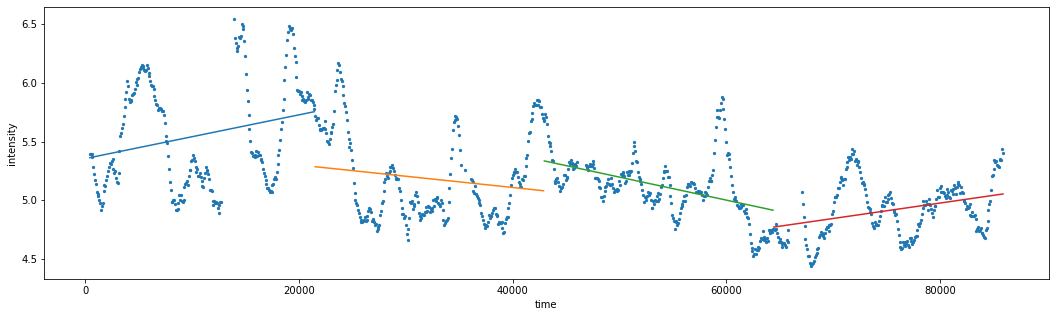

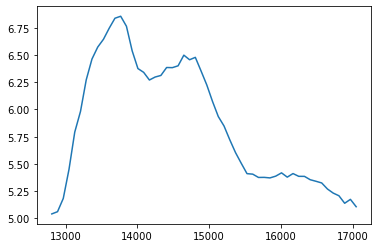

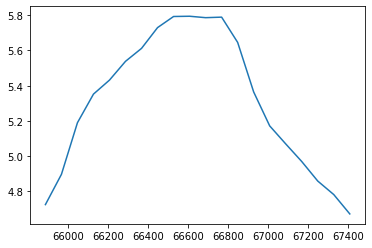

mean 5.086108218071334
std 0.6738219616064051
median 4.879693047973244
max 8.028151785785502
increment 3.148458737812258


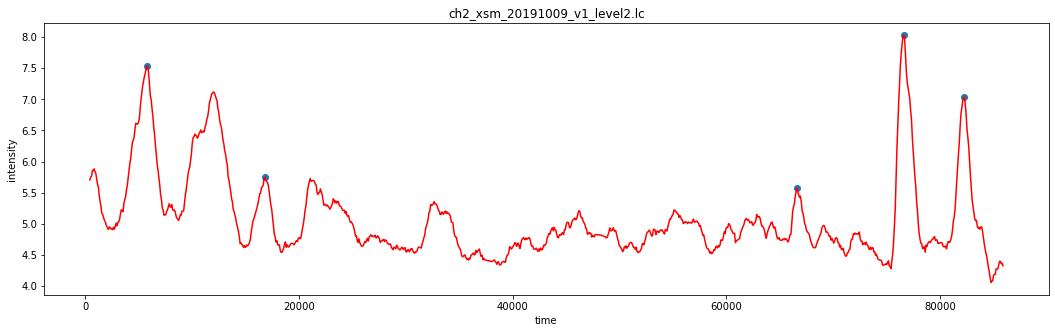

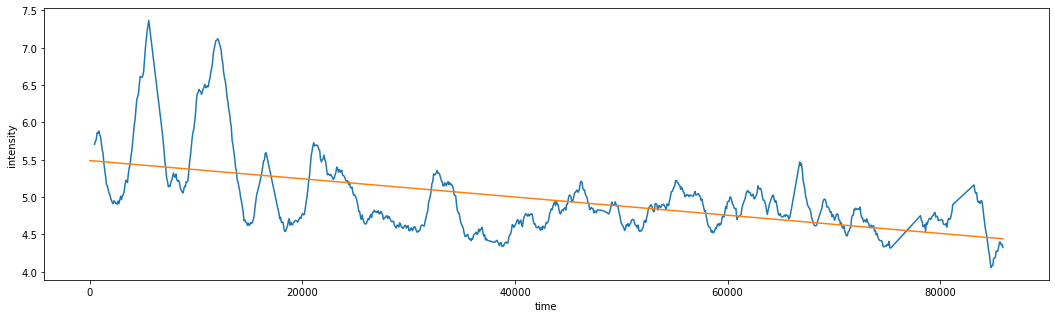

mark:  21477.875
break, array_bg_times etc ready 


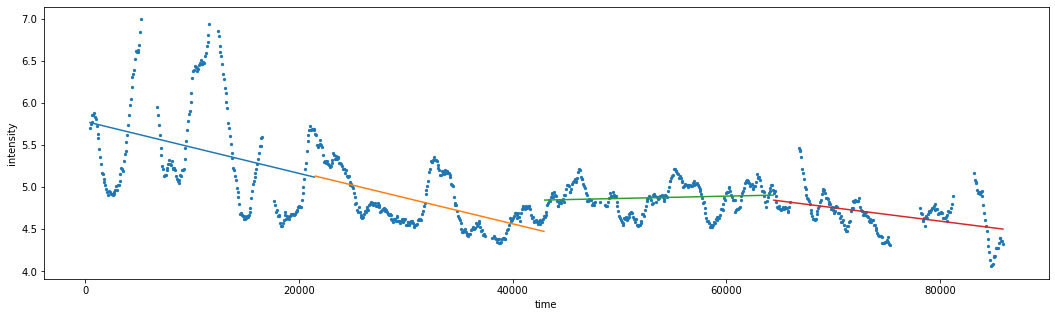

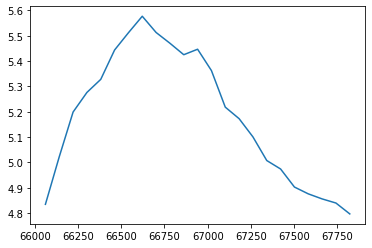

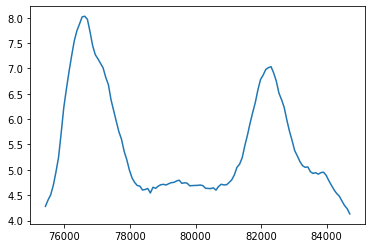

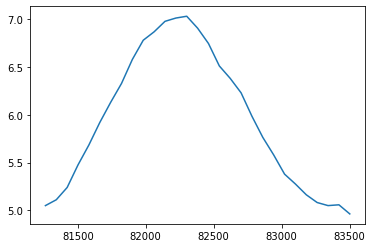

In [2]:
%matplotlib inline



def biquad(x,a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

for i in range(1,10):
    s = 'ch2_xsm_2019100' + str(i) + '_v1_level2.lc'
    
    dat = prepare_data(s)
    fl_marks, time, intensity = display_data(dat)#preliminary flare_marks are returned
    data_len = len(time)
    #fl_marks_broken = split_flare_marks(n,fl_marks,time[-1])
    #print(fl_marks_broken)
    plt.figure(figsize = (18,5))
    plt.xlabel('time')
    plt.ylabel('intensity')
    i_new,t_new = remove_flares(fl_marks, time, intensity) #flareless backround returned
    
                #added initial and final values incase the fit gets drastically wrong - required for some binning values on some days
    
    #i_new.insert(0,intensity[0])
    #t_new.insert(0,time[0])
    #i_new = shrink_std(i_new)
    popt, pcov = curve_fit(line, t_new, i_new) #fit linear background

    m = popt[0]
    c = popt[1]
    plt.plot(t_new, i_new)
    arr = np.linspace(0,time[-1],200)
    y1 = []
    for i in arr:
        y1.append(line(i,m,c))

    plt.plot(arr,y1)
    plt.show()
    
    plt.figure(figsize = (18,5))
    plt.xlabel('time')
    plt.ylabel('intensity')
    t_new, i_new = remove_outliers(t_new, i_new, m, c)#remove outliers
    plt.scatter(t_new, i_new,s=5)
    

    #now we will break the data into parts and fit lines to each part
    n_parts = 4
    mark = (time[-1]+10)/n_parts
    print('mark: ', mark)
    arr_bg_times = []
    arr_bg_intensities = []
    for i in range(n_parts):
        arr_t = []
        arr_i = []
        for j in range(len(t_new)):
            if mark*i < t_new[j] < mark*(i+1):
                arr_t.append(t_new[j])
                arr_i.append(i_new[j])
        arr_bg_times.append(arr_t)
        arr_bg_intensities.append(arr_i)
   # print(arr_bg_times)
    #print(arr_bg_intensities)
    
    print('break, array_bg_times etc ready ')
    
    m_arr = []
    c_arr = []
    
    for i in range(len(arr_bg_times)):
        popt,pcov = curve_fit(line, arr_bg_times[i], arr_bg_intensities[i])
        m = popt[0]
        c = popt[1]
        #plt.plot(arr_bg_times[i], arr_bg_intensities[i])
        #print(arr_bg_times[i])
        arr = np.linspace(arr_bg_times[i][0],arr_bg_times[i][-1],200)
        y1 = []
        
        for i in arr:
            y1.append(line(i,m,c))
       # print(arr)
        plt.plot(arr,y1)
        m_arr.append(m)
        c_arr.append(c)
    plt.show()

    flare_starts = np.zeros(len(fl_marks))
    for i in range(len(fl_marks)):
        flare_starts[i] = fl_marks[i][0]

    #print(flare_starts)
    std_bg = np.std(i_new)

    flares_t = []
    flares_i = []
    for i in range(0,len(time)):
        if time[i] in flare_starts:
            l_t = []
            l_i = []
            #start = time[i]
            started = True
            for j in range(len(time)-i):
                l_t.append(time[i+j])
                l_i.append(intensity[i+j])
                if intensity[i+j] -  intensity[i] < broken_lines(time[i+j],mark,m_arr,c_arr) - broken_lines(time[i],mark,m_arr,c_arr):
                    started = False
                    if len(l_t) > 10 and max(l_i) - min(l_i) > 1.4*std_bg :
                        flares_t.append(l_t)
                        flares_i.append(l_i)
                    break
            if started:
                started = False
                if len(l_t) > 10 and max(l_i) - min(l_i) > 1.4*std_bg :
                    flares_t.append(l_t)
                    flares_i.append(l_i)
    
    
    for i in range(len(flares_t)):
        #print(np.std(flares_i[i]))
        '''popt,pcov = curve_fit(convolution_flare, flares_t[i], flares_i[i],(max(flares_i[i])/10, flares_t[i][np.argmax(np.array(flares_i[i]))],10,0.01,np.mean(i_new)/10))
        a = popt[0]
        b = popt[1]
        c = popt[2]
        d = popt[3]
        e = popt[4]
        print(popt)
        #d = popt[3]
        #print(pcov)'''
        plt.plot(flares_t[i], flares_i[i])
        
        '''arr = np.linspace(flares_t[i][0],flares_t[i][-1],20)
        y1 = []
        for i in arr:
            y1.append(convolution_flare(i,a,b,c,d,e))
        plt.plot(arr,y1)'''
        plt.show()
    #print(i_new)

In [4]:
def gaussian(x,a,b,c,e):
    return a * np.exp(-((x-b)**2)/(2*c**2)) + e

def exponential(x,d,a,b):
    return  np.exp(-d*(x))


def convolution_flare(x, a,b,c,d,e):
    n = 100
    dt = x/n
    t = 0
    sum = 0
    for i in range(n):
        sum += gaussian(t,a,b,c,e)*exponential(x-t,d,a,b)*dt
        t += dt
    return sum




Text(0, 0.5, 'intensity (arbitrary)')

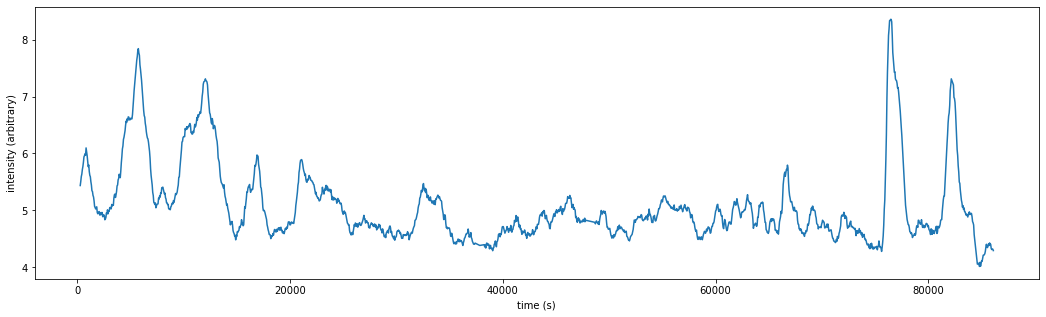

In [3]:
#plt.figure(dpi=100)
plt.figure(figsize=(18,5))
plt.plot(time, intensity)
plt.xlabel('time (s)')
plt.ylabel('intensity (arbitrary)')

In [4]:
from scipy.signal import find_peaks

In [11]:
day = 5
month = 10
year = 2019
s = f'ch2_xsm_{year}{month:02d}{day:02d}_v1_level2.lc'

dat = prepare_data(s)
%matplotlib qt


plt.figure(figsize=(18,5))
plt.plot(dat[0],dat[1],c = 'b')
plt.xlabel('time (s)')
plt.ylabel('intensity (arbitrary)')
plt.show()

fl_marks, time, intensity = display_data(dat)#preliminary flare_marks are returned

peaks = find_peaks(intensity, prominence=7)
plt.figure(figsize=(18,5))
plt.scatter(time, intensity)
plt.scatter(time[peaks[0]], intensity[peaks[0]], c='m', s=100)
plt.ylim(top=350)
plt.xlabel('time (s)')
plt.ylabel('intensity (arbitrary)')

mean 10.171619494722904
std 2.583413649868553
median 9.820403532548385
max 48.71064411510121
increment 38.89024058255283


Text(0, 0.5, 'intensity (arbitrary)')